# Introductory applied machine learning (INFR10069)

# Assignment 3: Object recognition

## Marking Breakdown

**70-100%** results/answer correct plus extra achievement at understanding or analysis of results. Clear explanations, evidence of creative or deeper thought will contribute to a higher grade.

**60-69%** results/answer correct or nearly correct and well explained.

**50-59%** results/answer in right direction but significant errors.

**40-49%** some evidence that the student has gained some understanding, but not answered the questions
properly.

**0-39%** serious error or slack work.

## Mechanics

You should produce a Jupyter notebook and a `.txt` file (see Part 2) in answer to this assignment.
**You need to submit these two files electronically as described below.**

Place your notebook and `.txt` files **only** in a directory called `iamlans` and submit this directory using the submit command on a DICE machine. The format is:

`submit iaml 3 iamlans`

You can check the status of your submissions with the `show_submissions` command.

**Late submissions:** The policy stated in the School of Informatics MSc Degree Guide is that normally you will not be allowed to submit coursework late. See http://www.inf.ed.ac.uk/teaching/years/msc/courseguide10.html#exam for exceptions to this, e.g. in case of serious medical illness or serious personal problems.

**Collaboration:** You may discuss the assignment with your colleagues, provided that the writing that you submit is entirely your own. That is, you should NOT borrow actual text or code from other students. We ask that you provide a list of the people who you've had discussions with (if any).


## Important Instructions

1. In the following questions you are asked to run experiments using Python (version 2.7) and the following packages:
    * Numpy
    * Pandas
    * Scikit-learn 0.17
    * Matplotlib
    * Seaborn

2. Before you start make sure you have set up a vitual environment (or conda environment if you are working on your own machine) and the required packages installed. Instructions on how to set-up the working enviornment and install the required packages can be found in `01_Lab_1_Introduction`.

3. Wherever you are required to produce code you should use code cells, otherwise you should use markdown cells to report results and explain answers.

4. The .csv files that you will be using are located at `./datasets` (the `datasets` directory is adjacent to this file).

5. **IMPORTANT:** Keep your answers brief and concise. Most questions can be answered with 2-3 lines of explanation (excluding coding questions), unless stated otherwise.

## Imports

In this assignment you are asked to import all the packages and modules you will need. Include all required imports and execute the cell below.

In [1]:
from __future__ import print_function, division
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.cross_validation import train_test_split, KFold, cross_val_predict, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.svm import SVC
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import RobustScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import maxabs_scale
from sklearn.metrics import confusion_matrix, log_loss


%matplotlib inline

# Your code goes here


/home/tom/miniconda2/envs/iaml/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Description of the dataset
In this assignment our goal is to recognize objects from 19 dierent visual classes (e.g. person, dog, cat, car, ...) in realistic scenes. The dataset consists of several thousands photographs harvested from the web. Each object of a relevant class has been manually annotated with a bounding box. Images can contain none, one or multiple objects of each class. We have prepared a [website](http://www.inf.ed.ac.uk/teaching/courses/iaml/2014/assts/asst3/images.html) where you can view the images.

Here we will focus on a single classiffication task: you will be required to classify images as to whether or not they contain a person. To save you time and to make the problem manageable with limited computational resources, we have preprocessed the dataset. We will use the [Bag of Visual Words](https://en.wikipedia.org/wiki/Bag-of-words_model_in_computer_vision) representation. That is, each image is represented by a 500 dimensional vector that contains the normalized count for each of 500 diffeerent visual words present in the respective image (a similar representation is used for the spambase dataset, just for real words). Visual words are based on [Scale-invariant feature transforms (SIFT)](https://en.wikipedia.org/wiki/Scale-invariant_feature_transform). SIFT features are essentially local orientation histograms and capture the properties of small image regions. They possess attractive invariance properties which make them well suited for our task (you can read more about SIFT features in [D.Lowe, IJCV 60(2):91- 110, 2004](http://link.springer.com/article/10.1023/B:VISI.0000029664.99615.94), but the details don't matter for the purpose of this assignment). Each SIFT feature is a 128 dimensional vector. From each image many SIFT features are extracted, typically > 2500 per image (features are extracted at regular intervals using a 15 pixel grid and at 4 different scales). To obtain visual words a representative subset of all extracted SIFT features from all images is chosen and clustered with k-means using 500 centres (such use of the k-means algorithm will be discussed in detail during the lecture). These 500 cluster centres form our visual words. The representation of a single image is obtained by first assigning each SIFT feature extracted from the image to the appropriate cluster (i.e. we determine the visual word corresponding to each feature by picking the closest cluster centre). We then count the number of features from that image assigned to each cluster (i.e. we determine how often each visual word is present in the image). This results in a 500 dimensional count vector for each image (one dimension for each visual word). The normalized version of this count vector gives the final representation of the image (normalized means that we divide the count vector by the total number of visual words in the image, i.e. the normalized counts sum to 1 for each image). Our dataset with all images is thus a $N \times 500$ dimensional matrix where `N` is the number of images. The resulting representation is much more compact and can be used directly to perform classiffication.

The full dataset has 520 attributes (dimensions). The first attribute (`imgID`) contains the image ID which allows you to associate a data point with an actual image. The next 500 attributes (`dim1`, ..., `dim500`) correspond to the normalized count vector. The last 19 attributes (`is_class`) indicate the presence of at least one object of a particular class in the image. In most of the experiments (unless explicitly noted otherwise) you will be asked to train classiffiers for classifying person vs. non-person images and only the `is_person` attribute and the 500 dimensional feature vector will be used. Do not use the additional class indicator attributes as features unless explicitly told to do so. 

In Part A we provide you with a training (`train_images partA.csv`) and a validation (`valid_images partA .csv`) dataset. In Part B we provide three data sets: a training set (`train_images partB.csv`), a validation set (`valid_images partB.csv`), and a test set (`test_images partB.csv`). The training and validation set contain valid labels. In the test set the labels are missing. The files are available from the GitHub repository. 

*Important: Throughout the assignment you will be given various versions of the dataset that are relevant
to a particular question. Please be careful to use the correct version of the dataset when instructed to do so.
If you use the wrong version of the dataset by mistake no marks will be awarded.*

## 1. Exploration of the dataset [70%]

### ========== Question 1.1 ==========
Load the datasets `train_images_partA.csv` and `valid_images_partA.csv` into two pandas DataFrame called `train_A` and `valid_A`. Display the number of data points and attributes in each of the two datasets.

In [2]:
# Your code goes here

data_path = os.path.join(os.getcwd(), 'datasets', 'train_images_partA.csv')
image_train = pd.read_csv(data_path, delimiter = ',')
data_path = os.path.join(os.getcwd(), 'datasets', 'valid_images_partA.csv')
image_val = pd.read_csv(data_path, delimiter = ',')

print("The number of data points of training set: {0}".format(image_train.shape[0]))
print("The number of attributes of training set: {0}".format(image_train.shape[1]))
print("The number of data points of validation set: {0}".format(image_val.shape[0]))
print("The number of attributes of validation set: {0}".format(image_val.shape[1]))

The number of data points of training set: 2093
The number of attributes of training set: 520
The number of data points of validation set: 1113
The number of attributes of validation set: 520


### ========== Question 1.2 ==========
Display and inspect the first 10 instances in the training dataset.

In [3]:
# Your code goes here
image_train.head(10)

image_train.describe()

,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,...,is_cow,is_diningtable,is_dog,is_horse,is_motorbike,is_person,is_pottedplant,is_sheep,is_sofa,is_tvmonitor
count,2093.000000,2093.000000,2093.000000,2093.000000,2093.000000,2093.000000,2093.000000,2093.000000,2093.000000,2093.000000,...,2093.000000,2093.000000,2093.000000,2093.000000,2093.000000,2093.000000,2093.000000,2093.000000,2093.000000,2093.000000
mean,0.001751,0.000756,0.004317,0.001853,0.002272,0.002220,0.001019,0.002446,0.002088,0.002746,...,0.017200,0.025323,0.088390,0.045867,0.048256,0.449116,0.040134,0.015289,0.032489,0.050167
std,0.001193,0.001406,0.003693,0.001340,0.001598,0.001741,0.000873,0.002910,0.001971,0.002328,...,0.130048,0.157140,0.283929,0.209247,0.214358,0.497523,0.196320,0.122729,0.177338,0.218342
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000833,0.000000,0.001359,0.000756,0.001116,0.001019,0.000340,0.000625,0.000744,0.001116,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.001563,0.000340,0.003397,0.001698,0.002038,0.001860,0.000744,0.001563,0.001698,0.002056,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.002378,0.000893,0.006324,0.002717,0.003057,0.003057,0.001488,0.003397,0.002717,0.003736,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,0.009851,0.016644,0.027514,0.010789,0.010417,0.021739,0.005774,0.029830,0.028372,0.020380,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### ========== Question 1.3 ==========
In this part we want to select the appopriate attributes (i.e. input features) for training our classifiers. These should be the attributes `dim1, dim2, ..., dim500`. Create a list which has as elements the **names** of the attributes of interest. 

In [4]:
# Your code goes here

interest_attributes = image_train.columns[1:501]

print(interest_attributes)

Index([u'dim1', u'dim2', u'dim3', u'dim4', u'dim5', u'dim6', u'dim7', u'dim8',
       u'dim9', u'dim10',
       ...
       u'dim491', u'dim492', u'dim493', u'dim494', u'dim495', u'dim496',
       u'dim497', u'dim498', u'dim499', u'dim500'],
      dtype='object', length=500)


### ========== Question 1.4 --- [1 mark] ==========
By using the list from Question 1.3 now create 4 numpy arrays `X_tr`, `X_val`, `y_tr` and `y_val` and store the training features, validation features, training targets, and validation targets, respectively. Your target vectors should correspond to the `is_person` attribute of the training and validation sets (also make sure you do not include this attribute in your training features). Display the dimensionalities (i.e shapes) of the 4 arrays and make sure your input data are 500-dimensional.

In [5]:
# Your code goes here
X_tr = image_train[interest_attributes]
X_val = image_val[interest_attributes]
y_tr = image_train['is_person']
y_val = image_val['is_person']

print("The dimesionality of X_tr is: {0}".format(X_tr.shape))
print("The dimesionality of X_val is: {0}".format(X_val.shape))
print("The dimesionality of y_tr is: {0}".format(y_tr.shape))
print("The dimesionality of y_val is: {0}".format(y_val.shape))

The dimesionality of X_tr is: (2093, 500)
The dimesionality of X_val is: (1113, 500)
The dimesionality of y_tr is: (2093,)
The dimesionality of y_val is: (1113,)


### ========== Question 1.5 ==========
Show two [countplots](https://seaborn.github.io/generated/seaborn.countplot.html?highlight=countplot#seaborn.countplot) of the targets in a single plot, one for the training and one for the validation set. Label axes appropriately and add a title to your plot. Use descriptive `xticklabels` instead of the default numeric ones.

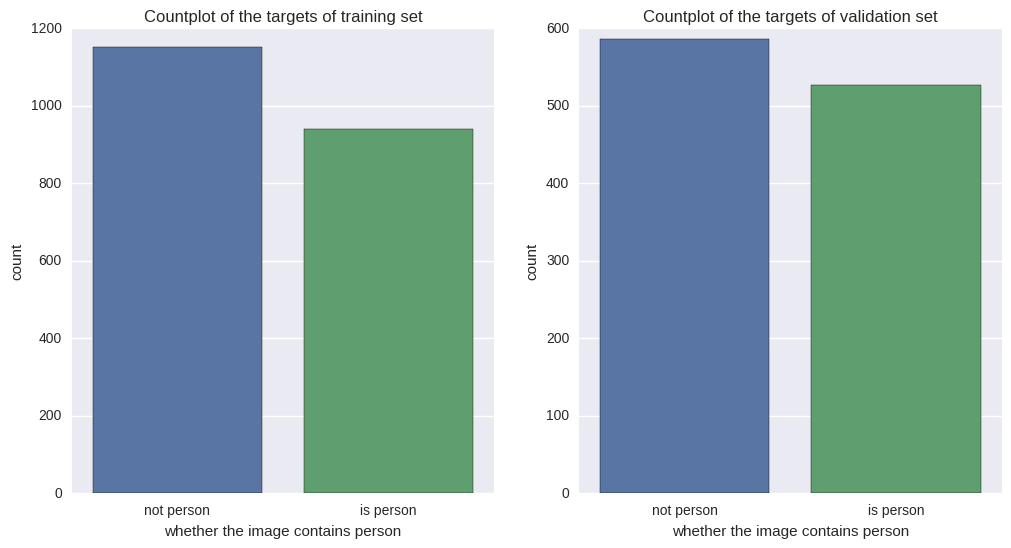

In [6]:
# Your code goes here

plt.figure(figsize=(12,6))

plt.subplot(121)
ax1 = sns.countplot(x = 'is_person',data = image_train)
ax1.set_xticklabels(['not person','is person'])
plt.title('Countplot of the targets of training set')
plt.xlabel('whether the image contains person')

plt.subplot(122)
ax2 = sns.countplot(x = 'is_person',data = image_val)
ax2.set_xticklabels(['not person','is person'])
plt.title('Countplot of the targets of validation set')
plt.xlabel('whether the image contains person')

plt.show()


### ========== Question 1.6 ==========
What would be a good choice for a baseline classifier to compare your results in the next steps against? What classification accuracy score does the baseline classifier achieve in the validation set?

*Your answer goes here*

I think a reasonable baseline would be the prediction based on the prior probability of the targets of training set. In this part, I choose the class with the highest prior probability to be the prediction result. Finally, the accuracy of baseline model I got is 0.526504941599.

In [7]:
# Your code goes here

count0 = 0
count1 = 0
for item in y_tr:
    if item == 0:
        count0 += 1
    else:
        count1 += 1
        
prob_0 = float(count0)/(count0+count1)
prob_1 = float(count1)/(count0+count1)
        
print("prior probability for is_person(0) is: {0:4f}".format(prob_0))
print("prior probability for is_person(1) is: {0:4f}".format(prob_1))

#generate the result of prior probability
seed = 10238029
random.seed(seed)
result_baseline = np.zeros(y_val.shape[0])
#for i in range(result_baseline.shape[0]):
#    result_baseline[i] = 1
#    rd = random.random()
#    if(rd >= prob_0):
#        result_baseline[i] = 1
    
correct = 0
for i in range(result_baseline.shape[0]):
    if result_baseline[i] == y_val[i]:
        correct += 1

acc = float(correct)/result_baseline.shape[0]
#print(result_baseline)
print('Since the prior probablity of class 0 is higher, I choose it as prediction result of baseline.')
print("The accuracy of baseline is: {0:4f}".format(acc))

prior probability for is_person(0) is: 0.550884
prior probability for is_person(1) is: 0.449116
Since the prior probablity of class 0 is higher, I choose it as prediction result of baseline.
The accuracy of baseline is: 0.526505


### ========== Question 1.7 ==========
Train a [`LogisticRegression`](http://scikit-learn.org/0.17/modules/generated/sklearn.linear_model.LogisticRegression.html) classifier by using default settings, except for the `solver` parameter which you should set to `lbfgs`. Report the classification accuracy score in the training and validation sets and compare to that of the baseline classifier. Comment in 1-2 sentences the results. You may include any additional plot(s) if you wish to justify your explanation.

Classification accuracy on training set: 0.551
Classification accuracy on validation set: 0.527
The Confusion Matrix: 
[[ 1.  0.]
 [ 1.  0.]]


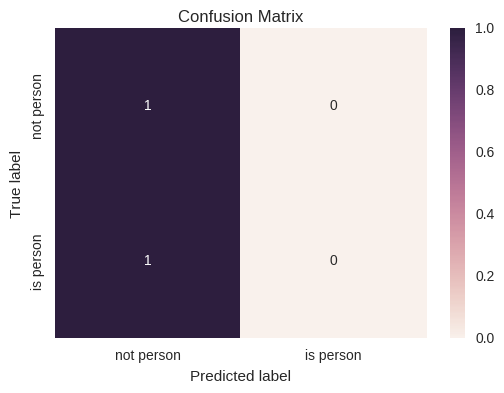

In [8]:
# Your code goes here
lr = LogisticRegression(solver='lbfgs')
lr.fit(X_tr, y_tr)
print('Classification accuracy on training set: {:.3f}'.format(lr.score(X_tr, y_tr)))
print('Classification accuracy on validation set: {:.3f}'.format(lr.score(X_val, y_val)))


#plot the confusion matrix
#print(np.unique(predict))
cm = confusion_matrix(y_val,lr.predict(X_val))
cm_nor = cm/cm.sum(axis=1)[:, np.newaxis]
print("The Confusion Matrix: \n{0}".format(cm_nor))
ticklabels = ['not person','is person']
sns.heatmap(cm_nor, xticklabels = ticklabels, yticklabels = ticklabels, vmin=0., vmax=1., annot=True)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

*Your answer goes here*

Compared with the result I got in Question 1.6, I got the a similar accuracy in this question. So, it seems that the logisticregression doesn't provide a better classifier in this case. Also, I use confusion to show the perdicted result, we could see that the logisticregression doesn't have the prediction result of 'is person'. As for the reason of this, I think it related to the task itself -- this is an classification task, and regression method is not suitable for this task.

### ========== Question 1.8 ==========
Display the means and standard deviations of the first 5 features in the training set. *Hint: you want to compute the means and standard deviations across the columns of your arrays. Make sure you make appropriate use of the `axis` parameter.*

In [9]:
# Your code goes here
np.set_printoptions(precision=3)

means = np.mean(X_tr.iloc[:,0:5],axis = 0)
std = np.std(X_tr.iloc[:,0:5],axis = 0)

print("means: \n{0}".format(means))
print("standard deviations: \n{0}".format(std))


means: 
dim1    0.001751
dim2    0.000756
dim3    0.004317
dim4    0.001853
dim5    0.002272
dtype: float64
standard deviations: 
dim1    0.001193
dim2    0.001406
dim3    0.003693
dim4    0.001340
dim5    0.001598
dtype: float64


### ========== Question 1.9 ==========
Feature standardisation is a pre-processing technique used to transform data so that they have zero mean and unit standard deviation. For many algorithms, this is a very important step for training models (both regression and classification). Read about [feature standardisation](http://scikit-learn.org/0.17/modules/preprocessing.html) and make sure you understand what kind of transformation this method applies to the data.

`Scikit-learn` offers an [implementation](http://scikit-learn.org/0.17/modules/generated/sklearn.preprocessing.StandardScaler.html) of feature standardisation. Create a standardiser and fit it by using training features only. Then transform both your input and validation input features. 

Once your training and validation input data have been transformed, display the means and standard deviations of the first 5 attributes for **both** the training and validation sets. Are the results as you expected? Explain your answer in 2-3 sentences. 

**IMPORTANT: You should use the transformed data for the rest of part A**.

In [10]:
# Your code goes here
#with_mean?
ss = StandardScaler()
ss.fit(X_tr)
#print(X_tr.dim1.unique())

tran_X_tr = ss.transform(X_tr)
tran_X_val = ss.transform(X_val)

print("The means of the first 5 attributes for training set: \n{0}".format(np.mean(tran_X_tr[:,:5],axis = 0)))
print("The standard deviations of the first 5 attributes for training set: \n{0}".format(np.std(tran_X_tr[:,:5],axis = 0)))
print("The means of the first 5 attributes for validation set: \n{0}".format(np.mean(tran_X_val[:,:5],axis = 0)))
print("The standard deviations of the first 5 attributes for validation set: \n{0}".format(np.std(tran_X_val[:,:5],axis = 0)))


The means of the first 5 attributes for training set: 
[ -3.395e-17  -2.207e-17   2.444e-16   1.426e-16  -5.771e-17]
The standard deviations of the first 5 attributes for training set: 
[ 1.  1.  1.  1.  1.]
The means of the first 5 attributes for validation set: 
[-0.006 -0.038  0.109  0.094  0.031]
The standard deviations of the first 5 attributes for validation set: 
[ 1.013  0.97   1.049  1.057  0.975]


*Your answer goes here*

The result is just as what I expected -- the feature values are centered around 0 and have same standard deviations. I think this standardscaler makes the data more suitable for SVM.

### ========== Question 1.10 ==========
By using the transformed input data, retrain a `LogisticRegression` classifier. Again, set the `solver` parameter to `lbfgs` and use default settings for the other parameters. Report the classification accuracy in both the training and validation sets. How does your model compare to the baseline classifier from Question 1.6? You may use additional plot(s) to support your explanation.

Classification accuracy on transformed training set: 0.811
Classification accuracy on transformed validation set: 0.643
The Confusion Matrix: 
[[ 0.686  0.314]
 [ 0.404  0.596]]


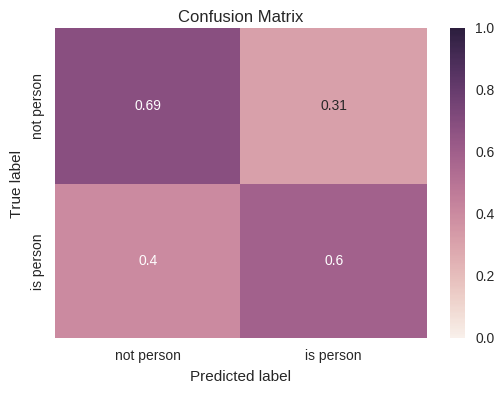

In [11]:
# Your code goes here

lr_tran = LogisticRegression(solver='lbfgs')
lr_tran.fit(tran_X_tr, y_tr)
print('Classification accuracy on transformed training set: {:.3f}'.format(lr_tran.score(tran_X_tr, y_tr)))
print('Classification accuracy on transformed validation set: {:.3f}'.format(lr_tran.score(tran_X_val, y_val)))

cm_tran = confusion_matrix(y_val,lr_tran.predict(tran_X_val))
cm_tran_nor = cm_tran/cm_tran.sum(axis=1)[:, np.newaxis]
print("The Confusion Matrix: \n{0}".format(cm_tran_nor))
ticklabels = ['not person','is person']
sns.heatmap(cm_tran_nor, xticklabels = ticklabels, yticklabels = ticklabels, vmin=0., vmax=1., annot=True)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


*Your answer goes here*

This time, the logisticregression has different predicted value. Compared to the baseline classifier, this model performs better.

### ========== Question 1.11 ==========
So far we have used default settings for training the logistic regression classifier. Now, we want to use [K-fold cross-validation](http://scikit-learn.org/0.17/modules/generated/sklearn.cross_validation.KFold.html) to optimise the regularisation parameter `C`. The regularisation parameter controls the degree to which we wish to penalise large magnitudes for the weight vector. Thus, it helps us prevent overfitting and, for logistic regression, it additionally controls the level of confidence in making predictions.

We would like to optimise this parameter **by using the transformed training dataset only** and not the validation set. Create a 3-fold cross-validation object for the training dataset. Set the `shuffle` parameter to `True` and the `random_state` to `0`. By using the cross-validation iterator, display the number of test samples in each iteration fold.

In [12]:
# Your code goes here
kf = KFold(tran_X_tr.shape[0], n_folds = 3, shuffle = True, random_state = 0)

count = 1
for train_index, test_index in kf:
    print("{0} Fold: number of test samples: {1}".format(count,test_index.shape[0]))
    count += 1


1 Fold: number of test samples: 698
2 Fold: number of test samples: 698
3 Fold: number of test samples: 697


### ========== Question 1.12 ========== 
Now we want to test out different settings for the regularisation parameter `C` by using the cross-validation iterator from the previous question. For each iteration, we want to train multiple classifiers by using a range of values for `C` and then compute the performance within each CV fold. You should use a log-range for `C` from `1e-5` to `1e5` by using 20 equally-spaced values *(hint: look at the `logspace()` function in numpy)*. 

Create a 2-dimensional array and, for each cross-validation fold and parameter setting pair, compute and store the classification accuracy score e.g. store the score of fold 0 with parameter setting 1 at score_array[0,1]. As previously, set the `solver` parameter to `lbfgs` and use default settings for the other parameters.

*(hint: your may want to use two loops in your code; one iterating over CV folds and another one iterating over the values for `C`)*. 

In [13]:
# Your code goes here

C = np.logspace(-5.0,5.0,num=20)
print("values of regularisation parameters: \n{0}".format(C))

kfcount = 0
Ccount = 0
score_array = np.zeros((3,20))
for train_index, test_index in kf:
    
    for c in C:
        test_lr = LogisticRegression(solver = 'lbfgs', C=c)
        test_lr.fit(tran_X_tr[train_index],y_tr[train_index])
        score_array[kfcount,Ccount] = test_lr.score(tran_X_tr[test_index],y_tr[test_index])
        Ccount += 1
    Ccount = 0
    kfcount += 1
    
print("score array: \n{0}".format(score_array))
    


values of regularisation parameters: 
[  1.000e-05   3.360e-05   1.129e-04   3.793e-04   1.274e-03   4.281e-03
   1.438e-02   4.833e-02   1.624e-01   5.456e-01   1.833e+00   6.158e+00
   2.069e+01   6.952e+01   2.336e+02   7.848e+02   2.637e+03   8.859e+03
   2.976e+04   1.000e+05]
score array: 
[[ 0.573  0.629  0.668  0.672  0.688  0.696  0.675  0.67   0.653  0.659
   0.659  0.653  0.649  0.646  0.646  0.649  0.646  0.646  0.649  0.649]
 [ 0.546  0.632  0.695  0.719  0.729  0.735  0.702  0.675  0.655  0.636
   0.632  0.633  0.626  0.628  0.628  0.626  0.626  0.626  0.628  0.626]
 [ 0.548  0.636  0.643  0.656  0.68   0.7    0.681  0.67   0.663  0.644
   0.633  0.626  0.624  0.624  0.624  0.624  0.624  0.624  0.624  0.624]]


### ========== Question 1.13 ========== 
Plot the mean classification performance (across CV folds) of the logistic regression classifier against the regularisation parameter `C` by using the range from Question 1.12. Use a logarithmic scale for the x-axis and label both axes appropriately. 

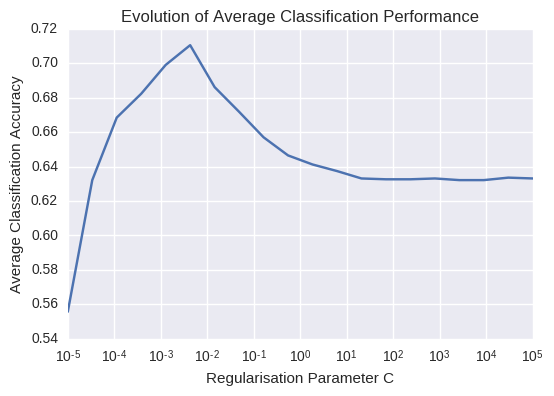

In [14]:
# Your code goes here

mean_acc = score_array.mean(axis=0)

plt.plot(C, mean_acc)
plt.xscale('log')
plt.xlabel('Regularisation Parameter C')
plt.ylabel('Average Classification Accuracy')
plt.title('Evolution of Average Classification Performance')
plt.show()



### ========== Question 1.14 ==========
Find and display the optimal value for the regularisation parameter `C` of the logistic classifier by using your results from Question 1.12. Similarly to Question 1.13, consider the mean classifiation accuracy across CV folds. By using the optimal value (i.e. the one that yields the highest average classification accuracy) train a new `LogisticRegression` classifier and report the classification accuracy on the validation set. *(Hint: Do not pick the optimal value "by hand", instead use an appropriate numpy function).*

In [15]:
# Your code goes here
opt_C = C[mean_acc.argmax()]
print("The optimal value for paramerter C is: {0:.4f}".format(opt_C))

lr114 = LogisticRegression(solver = 'lbfgs', C=opt_C)
lr114.fit(tran_X_tr,y_tr)
print("The classification accuracy of new LR classifier on validation set is: {0:.4f}".format(lr114.score(tran_X_val,y_val)))

The optimal value for paramerter C is: 0.0043
The classification accuracy of new LR classifier on validation set is: 0.6963


### ========== Question 1.15 ========== 
Scikit-learn offers a [`LogisticRegressionCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.linear_model.LogisticRegressionCV.html) module which implements Logistic Regression with builtin cross-validation to find out the optimal `C` parameter. You can specify the range for the `C` parameter, as well as the cross-validation method you want to use with the `Cs` and `cv` parameters, respectively. Use the `C` range you set up in Question 1.12 and the 3-fold cross-validation iterator from Question 1.11. Once again, train the models by using the `lbfgs` optimisation method and display the optimal value for the parameter `C`. Finally, display the classification accuracy on the validation set. Can you verify that your results are consistent with those from Question 1.14?

In [16]:
# Your code goes here

lrcv115 = LogisticRegressionCV(Cs = C,cv = kf, solver = 'lbfgs')
lrcv115.fit(tran_X_tr,y_tr)
acc115 = lrcv115.score(tran_X_val,y_val)
print("The optimal value for parameter C is: {0:.4f}".format(lrcv115.C_[0]))
print("The classification accuracy on the validation set is: {0:.4f}".format(acc115))
print("Yes! Get the same result as Question 1.14!")

The optimal value for parameter C is: 0.0043
The classification accuracy on the validation set is: 0.6963
Yes! Get the same result as Question 1.14!


### ========== Question 1.16 ==========
Now, we want to validate the importance of various features for classification. For this purpose, we will use a [`RandomForestClassifier`](http://scikit-learn.org/0.17/modules/generated/sklearn.ensemble.RandomForestClassifier.html) (you might want to refer to Lab_3 if you are unsure how we can estimate feature importances with decision tree and random forest models).

Initialise a random forest classifier and fit the model by using training data only and 500 trees (i.e. `n_estimators`). Set the `RandomState` equal to 31 to ensure reproducible results. Report the accuracy score on both the training and validation sets.

In [17]:
# Your code goes here
rfc116 = RandomForestClassifier(criterion = 'entropy',n_estimators=500,random_state=31)
rfc116.fit(tran_X_tr,y_tr)
acc_train116 = rfc116.score(tran_X_tr,y_tr)
acc_val116 = rfc116.score(tran_X_val,y_val)

print("The accuracy score of RFC on training sets is: {:.4f}".format(acc_train116))
print("The accuracy score of RFC on validation sets is: {:.4f}".format(acc_val116))



The accuracy score of RFC on training sets is: 1.0000
The accuracy score of RFC on validation sets is: 0.6981


### ========== Question 1.17 ==========
Comment on the results above. Do you find the discrepancy between training and validation accuracies surprising?

*Your answer goes here*

Yes, it's weird that the accuracy on training sets is 1.0 and the accuracy on validation sets is only 0.69. I think the reason of this is that the RandomForestClassifier is overfitting on training sets and this makes the accuracy on validation sets lower.

### ========== Question 1.18 ==========
By using the random forest model from the previous question order the features by descending importance and display the names of the 50 most important features.

In [18]:
# Your code goes here
index118 = rfc116.feature_importances_.argsort()[-50:][::-1]
print("The name of the 50 most important features are: \n{0}".format(X_tr.columns[index118]))

The name of the 50 most important features are: 
Index([u'dim21', u'dim479', u'dim51', u'dim360', u'dim283', u'dim76', u'dim4',
       u'dim461', u'dim274', u'dim330', u'dim263', u'dim343', u'dim348',
       u'dim217', u'dim222', u'dim347', u'dim74', u'dim356', u'dim398',
       u'dim423', u'dim500', u'dim73', u'dim485', u'dim214', u'dim326',
       u'dim254', u'dim483', u'dim92', u'dim25', u'dim322', u'dim329',
       u'dim427', u'dim17', u'dim288', u'dim90', u'dim440', u'dim48',
       u'dim206', u'dim171', u'dim154', u'dim134', u'dim54', u'dim96',
       u'dim315', u'dim85', u'dim312', u'dim15', u'dim35', u'dim188',
       u'dim442'],
      dtype='object')


### ========== Question 1.19 ==========
Next, we would like to test out the performance of support vector classification and experiment with different kernels. 
By using training data only and default parameter settings, train three support vector classifiers with the following kernels: linear, radial basis function, and polynomial. Report the classification accuracy of each of the three classifiers on both the training and validation sets.

In [19]:
# Your code goes here
kernels = ['linear','rbf','poly']

for item in kernels:
    svc = SVC(kernel=item)
    svc.fit(tran_X_tr,y_tr)
    acc_train119 = svc.score(tran_X_tr,y_tr)
    acc_val119 = svc.score(tran_X_val,y_val)
    print("The classification accuracy of {0} SVC on training set is: {1:.4f}".format(item,acc_train119))
    print("The classification accuracy of {0} SVC on validation set is: {1:.4f}".format(item,acc_val119))

The classification accuracy of linear SVC on training set is: 0.8423
The classification accuracy of linear SVC on validation set is: 0.6388
The classification accuracy of rbf SVC on training set is: 0.9107
The classification accuracy of rbf SVC on validation set is: 0.7296
The classification accuracy of poly SVC on training set is: 0.9909
The classification accuracy of poly SVC on validation set is: 0.7017


### ========== Question 1.20 ==========
At this point, we would like to get an idea of what kind of decision boundaries we can get with the three types of SVM kernels we introduced in the previous question. For visualisation, however, we can only make use of 2D input data. For this purpose, we select to use the 21st and 76th columns of our training features (*hint: remember that Python uses 0-based indexing*). 

Execute the cell below to define a useful function which we will be using to plot the decision boundaries *(it is also not a bad idea to try to understand what this functions does)*. 

Then train three distinct SVM classifiers by using the 2D input data mentioned above and default parameters:
* a linear SVC
* an RBF SVC 
* a polynomial SVC

Finally, create a list containing the three classifiers you have just trained. Use this list as an input to the provided function along with the used training features and observe the outcome. You can use the additional `title` parameter to set the titles in the subplots. Comment on the results by using 1-2 sentences.

*(Acknowledgement: this Question has been heavily based on [this example](http://scikit-learn.org/0.17/auto_examples/svm/plot_iris.html) from scikit-learn's documentation.)*

In [20]:
def show_svc_decision_boundaries(clfs, X, title=None):
    """Plots decision boundaries for classifiers with 2D inputs.
    
    Parameters
    ----------
    clf : list
        Classifiers for which decision boundaries will be displayed.
    X : array
        Input features used to train the classifiers.
    title : list, optional
        Titles for classifiers.
    
    """
    
    assert X.shape[1] == 2 # Input should be 2D
    if title is not None:
        assert len(clfs) == len(title)
    
    h = .04 # step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    plt.figure(figsize=(15,5))
    for i, clf in enumerate(clfs):
        plt.subplot(1, len(clfs), i + 1)
        plt.subplots_adjust(wspace=0.4, hspace=0.4)
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)
        # Training points
        plt.scatter(X[:, 0], X[:, 1], c=y_tr, cmap=plt.cm.Paired)
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.xlim(xx.min(), xx.max())
        plt.ylim(yy.min(), yy.max())
        plt.xticks(())
        plt.yticks(())
        if title is not None:
            plt.title(title[i])

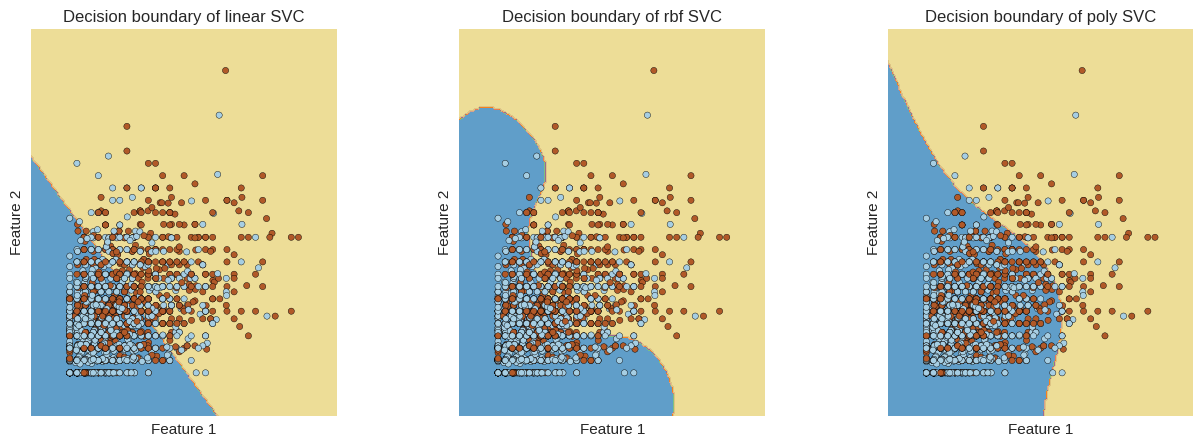

In [21]:
# Your code goes here
svc_data = tran_X_tr[:,[20,75]]
clflist = []
kernels = ['linear','rbf','poly']
titles120 = ['Decision boundary of linear SVC',
             'Decision boundary of rbf SVC',
             'Decision boundary of poly SVC']

count = 0
for item in kernels:
    svc = SVC(kernel=item)
    svc.fit(svc_data,y_tr)
    clflist.append(svc)
    count += 1

show_svc_decision_boundaries(clflist,svc_data,titles120)


*Your answer goes here*

From the accuracy of above question, the rbf kernel gives a better accuracy and the result is obvious shown in the plots. The rbf plot's boundary seems like the most fitting one and it's obvious that the decision boundary of linear model is very rough. As for the poly kernel, it gives a curve boundary but is not very suitable for the data.

### ========== Question 1.21 ==========
So far we have used default parameters for training the SVM classifiers. Now we want to tune the parameters by using cross-validation. 

By using the `K-fold` iterator from Question 1.11 and training data only, estimate the classification accuracy of an SVM classifier with RBF kernel, while you vary the penalty parameter `C` in a logarithmic range `np.logspace(-2, 3, 10)`. Set the kernel coefficient parameter `gamma` to `auto` for this question. 

Plot the mean cross-validated classification accuracy against the regularisation parameter `C` by using a log-scale for the x-axis. Display the highest obtained mean accuracy score and the value of `C` which yielded it. Label axes appropriately. 

Finally, train a classifier by using the optimal value for this parameter (without using cross-validation at this stage) and report the classification accuracy on the training and validation sets. 

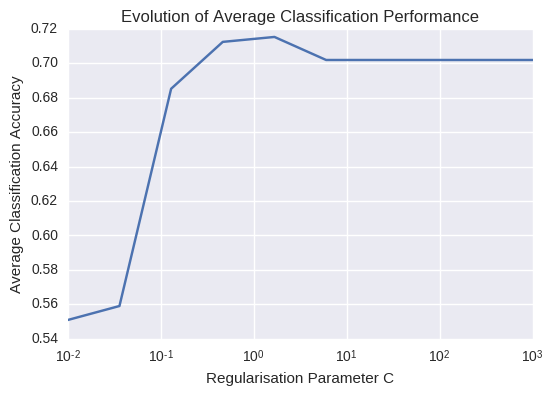

The highest obtained mean accuracy is: 0.7152
The value of the corresponding parameter C is: 1.6681
The classification accuracy of optimal(C) SVC on training set is: 0.9747
The classification accuracy of optimal(C) SVC on validation set is: 0.7278


In [22]:
# Your code goes here

C_svm = np.logspace(-2,3,10)

kfcount = 0
Ccount = 0
score_array_svm = np.zeros((3,10))
for train_index, test_index in kf:    
    for c in C_svm:
        svc121 = SVC(kernel='rbf',C=c,gamma='auto')
        svc121.fit(tran_X_tr[train_index],y_tr[train_index])
        score_array_svm[kfcount,Ccount] = svc121.score(tran_X_tr[test_index],y_tr[test_index])
        Ccount += 1
    Ccount = 0
    kfcount += 1

score_array_svm_mean = score_array_svm.mean(axis=0)

plt.plot(C_svm,score_array_svm_mean)
plt.xscale('log')
plt.xlabel('Regularisation Parameter C')
plt.ylabel('Average Classification Accuracy')
plt.title('Evolution of Average Classification Performance')
plt.show()

cor_C = C_svm[score_array_svm_mean.argmax()]
print("The highest obtained mean accuracy is: {0:.4f}".format(score_array_svm_mean.max()))
print("The value of the corresponding parameter C is: {0:.4f}".format(cor_C))
      
svc121_fin = SVC(kernel='rbf',C=cor_C,gamma='auto')
svc121_fin.fit(tran_X_tr,y_tr)
score121_train_fin = svc121_fin.score(tran_X_tr,y_tr)
score121_val_fin = svc121_fin.score(tran_X_val,y_val)
print("The classification accuracy of optimal(C) SVC on training set is: {0:.4f}".format(score121_train_fin))
print("The classification accuracy of optimal(C) SVC on validation set is: {0:.4f}".format(score121_val_fin))



### ========== Question 1.22 ==========
Now we turn to the kernel coefficient `gamma` parameter. By using the same procedure as in the previous question, estimate the classification accuracy of an SVM classifier with RBF kernel while you vary the `gamma` parameter in a logarithmic range `logspace(-5, 0, 10)`. Fix the penalty parameter `C=1.0`.

Plot the mean cross-validated classification accuracy against the parameter `gamma` by using a log-scale for the x-axis. Display the highest obtained mean accuracy score and the value of `gamma` which yielded it.  Label axes appropriately.

Finally, train a classifier by using the optimal value for this parameter (without using cross-validation at this stage) and report the classification accuracy on the training and validation sets. 

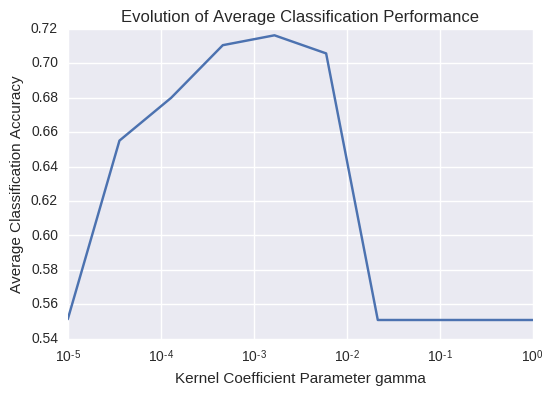

The highest obtained mean accuracy is: 0.7162
The value of the corresponding kernel coefficient parameter gamma is: 0.0017
The classification accuracy of optimal(gamma) SVC on training set is: 0.8911
The classification accuracy of optimal(gamma) SVC on validation set is: 0.7269


In [23]:
# Your code goes here

gamma_svm = np.logspace(-5,0,10)

kfcount = 0
Ccount = 0
score_array_svm = np.zeros((3,10))
for train_index, test_index in kf:    
    for gamma in gamma_svm:
        svc121 = SVC(kernel='rbf',C=1.0,gamma=gamma)
        svc121.fit(tran_X_tr[train_index],y_tr[train_index])
        score_array_svm[kfcount,Ccount] = svc121.score(tran_X_tr[test_index],y_tr[test_index])
        Ccount += 1
    Ccount = 0
    kfcount += 1

score_array_svm_mean = score_array_svm.mean(axis=0)

plt.plot(gamma_svm,score_array_svm_mean)
plt.xscale('log')
plt.xlabel('Kernel Coefficient Parameter gamma')
plt.ylabel('Average Classification Accuracy')
plt.title('Evolution of Average Classification Performance')
plt.show()

cor_gamma = gamma_svm[score_array_svm_mean.argmax()]
print("The highest obtained mean accuracy is: {0:.4f}".format(score_array_svm_mean.max()))
print("The value of the corresponding kernel coefficient parameter gamma is: {0:.4f}".format(cor_gamma))
      
svc122_fin = SVC(kernel='rbf',C=1.0,gamma=cor_gamma)
svc122_fin.fit(tran_X_tr,y_tr)
score122_train_fin = svc122_fin.score(tran_X_tr,y_tr)
score122_val_fin = svc122_fin.score(tran_X_val,y_val)
print("The classification accuracy of optimal(gamma) SVC on training set is: {0:.4f}".format(score122_train_fin))
print("The classification accuracy of optimal(gamma) SVC on validation set is: {0:.4f}".format(score122_val_fin))


### ========== Question 1.23 ==========
Now we wish to tune both the `C` and `gamma` parameters simultaneously. To save computational time, we will now constrain the parameter search space. Define a `4 X 4` grid for the two parameters, as follows:
* `C`: `np.logspace(-2, 1, 4)`
* `gamma`: `np.logspace(-4, -1, 4)`

Estimate the mean cross-validated classification accuracy by using training data only and all possible configurations for the two parameters. 

Use a [heatmap](https://seaborn.github.io/generated/seaborn.heatmap.html?highlight=heatmap#seaborn.heatmap) to visualise the mean cross-validated classification accuracy for all `C`-`gamma` pairs. Label axes appropriately and display the values for `C` and `gamma` for the best performing configuration. 

Finally, by using the optimal configuration, train a classifier (without using cross-validation) and report the classification accuracy on the training and validation sets.

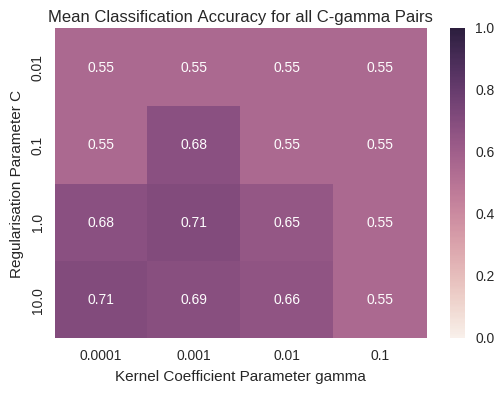

The value of the optimal regularisation parameter C is: 1.0000
The value of the optimal kernel coefficient parameter gamma is: 0.0010
The classification accuracy of optimal pairs SVC on training set is: 0.8347
The classification accuracy of optimal pairs SVC on validation set is: 0.7215


In [24]:
# Your code goes here 
C_123 = np.logspace(-2, 1, 4)
gamma_123 = np.logspace(-4, -1, 4)

tune_score = np.zeros((4,4))
Ccount = 0
Gammacount = 0
for c in C_123:
    for gamma in gamma_123:        
        tune_svm = SVC(kernel = 'rbf',C = c,gamma = gamma)
        tune_svm_result = cross_val_predict(tune_svm,tran_X_tr,y_tr,kf)
        #tune_svm.fit(tran_X_tr,y_tr)
        #tune_score[Ccount,Gammacount] = tune_svm.score(tran_X_val,y_val)
        tune_score[Ccount,Gammacount] = accuracy_score(tune_svm_result,y_tr)
        Gammacount += 1
    Gammacount = 0
    Ccount += 1

sns.heatmap(data = tune_score, xticklabels=gamma_123, yticklabels=C_123, vmin=0., vmax=1., annot=True)
plt.ylabel('Regularisation Parameter C')
plt.xlabel('Kernel Coefficient Parameter gamma')
plt.title('Mean Classification Accuracy for all C-gamma Pairs')
plt.show()

optimal_C = C_123[np.unravel_index(tune_score.argmax(),[4,4])[0]]
optimal_gamma = gamma_123[np.unravel_index(tune_score.argmax(),[4,4])[1]]
print("The value of the optimal regularisation parameter C is: {0:.4f}".format(optimal_C))
print("The value of the optimal kernel coefficient parameter gamma is: {0:.4f}".format(optimal_gamma))

opt_svm = SVC(kernel='rbf', C = optimal_C, gamma = optimal_gamma)
opt_svm.fit(tran_X_tr,y_tr)
opt_svm_train_score = opt_svm.score(tran_X_tr,y_tr)
opt_svm_val_score = opt_svm.score(tran_X_val,y_val)

print("The classification accuracy of optimal pairs SVC on training set is: {0:.4f}".format(opt_svm_train_score))
print("The classification accuracy of optimal pairs SVC on validation set is: {0:.4f}".format(opt_svm_val_score))

### ========== Question 1.24 ==========
Is the classification accuracy on the validation set higher than in previous questions (1.22-1.23)? If not, can you explain why? Can you think of a way of further improving the performance of the classifier? You don't need to implement your suggestion at this stage. Would there be any associated problems with your suggested approach? 

*Your answer goes here*

This classification desn't provide a better classifier compared with the previous question and I think the reason to this is that in order to try more kinds of parameters, the number of samples for each parameters gets less, which makes samples can't cover all the situations. Instead of searching the optimal parameters, I think one way to improve the performance is to avoid overfitting -- stop the training process earlier.

### ========== Question 1.25 ==========
Now we want to evaluate the performance of an SVM classifier with polynomial kernel. Once again, we will tune the `degree` parameter by using cross-validation (similarly to what we did in Questions 1.21 and 1.22).

By using the `K-fold` iterator from Question 1.11 and training data only, estimate the classification accuracy of polynomial SVM classifier, while you vary the `degree` parameter in the range `np.arange(1,8)`. 

Plot the mean cross-validated classification accuracy against the polynomial degree. Display the highest obtained mean accuracy score and the value of the `degree` parameter which yielded it. Label axes appropriately. 

Finally, train a classifier by using the optimal value for this parameter (without using cross-validation at this stage) and report the classification accuracy on the training and validation sets. 

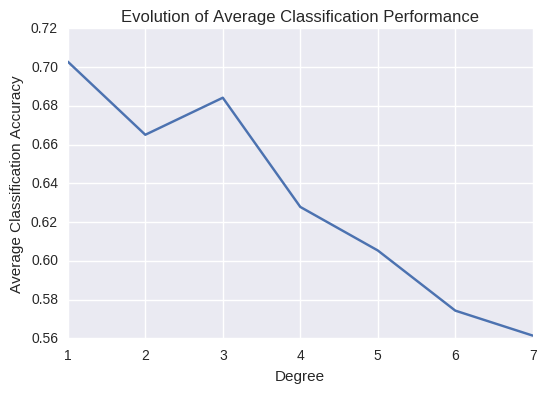

The highest obtained mean accuracy is: 0.7028
The value of the corresponding degree is: 1.0000
The classification accuracy of optimal(degree) poly SVC on training set is: 0.7836
The classification accuracy of optimal(degree) poly SVC on validation set is: 0.6891


In [25]:
# Your code goes here
degree_svm = np.arange(1,8)

poly_svm_score = np.zeros((3,7))
kfcount = 0
degreecount = 0
for train_index,test_index in kf:
    for degree in degree_svm:
        tune_svm = SVC(kernel='poly',degree = degree)
        tune_svm.fit(tran_X_tr[train_index],y_tr[train_index])
        poly_svm_score[kfcount,degreecount] = tune_svm.score(tran_X_tr[test_index],y_tr[test_index])
        degreecount += 1
    degreecount = 0
    kfcount += 1
        
poly_svm_score_mean = poly_svm_score.mean(axis=0)

plt.plot(degree_svm,poly_svm_score_mean)
plt.xlabel('Degree')
plt.ylabel('Average Classification Accuracy')
plt.title('Evolution of Average Classification Performance')
plt.show()

cor_degree = degree_svm[poly_svm_score_mean.argmax()]
print("The highest obtained mean accuracy is: {0:.4f}".format(poly_svm_score_mean.max()))
print("The value of the corresponding degree is: {0:.4f}".format(cor_degree))
      
svc125_fin = SVC(kernel='poly',degree=cor_degree)
svc125_fin.fit(tran_X_tr,y_tr)
score125_train_fin = svc125_fin.score(tran_X_tr,y_tr)
score125_val_fin = svc125_fin.score(tran_X_val,y_val)
print("The classification accuracy of optimal(degree) poly SVC on training set is: {0:.4f}".format(score125_train_fin))
print("The classification accuracy of optimal(degree) poly SVC on validation set is: {0:.4f}".format(score125_val_fin))


### ========== Question 1.26 ==========

You might have noticted that so far, we have used cross-validation for optimising the various tuning parameters (e.g. regularisation parameter in logistic regression, SVM kernel parameters) rather than hold-out validation, although we did have access to a validation set. Why do you think this is a good/bad idea? Give one advantage and one disadvantage of the two different approaches. Which one would you trust more in practice?

*Your answer goes here*

Hold-out validation is easy to achieve and could reduce the use of computation but it's really a rough method and it may make the classification result sensitive to the divide boundary (you may not get a stable result of the classifier). Instead, the cross-validation method could make the use of whole data set and it will finally make the classification result more stable. Obviously, if I have enough time to do the computation, I will choose cross-validation in practice.

### ========== Question 1.27 ==========

Reload the full training and validation data that contain all indicator variables for all object categories. Remove the `imgId` attribute but keep all of the class indicator variables in the dataset this time. Your training features should include all attributes except `is_person` which should be your target variable. 

Once again, use a [StandardScaler](http://scikit-learn.org/0.17/modules/generated/sklearn.preprocessing.StandardScaler.html) to standardise your training and validation features. Then train a Random Forest Classifier by using the entropy `criterion`, 500 `n_estimators`, and also set the `random_state` to 31. Report the classification accuracy on the training and validation sets.

Similarly to what we did in Question 1.18, order the features by decreasing importance and display the 50 most important features. 

Finally, answer the following questions:
* What do you notice by looking at the list of the best 50 features?
* How does the performance differ with respect to the case when the additional class indicator variables are not present (Question 1.16)? Relate your observations to the observed feature ranking.
* Would it be easy to make use of the results in practice? Briey explain your reasoning.

*(Hint: you might want to look at some of the [images](http://www.inf.ed.ac.uk/teaching/courses/iaml/2014/assts/asst3/images.html) to justify your explanations.)*

In [27]:
# Your code goes here

data_path = os.path.join(os.getcwd(), 'datasets', 'train_images_partA.csv')
image_train_127 = pd.read_csv(data_path, delimiter = ',')
data_path = os.path.join(os.getcwd(), 'datasets', 'valid_images_partA.csv')
image_val_127 = pd.read_csv(data_path, delimiter = ',')

image_train_127.drop('imgId',axis=1,inplace=True)
image_val_127.drop('imgId',axis=1,inplace=True)

X_tr_127 = image_train_127.drop('is_person',axis=1)
y_tr_127 = image_train_127.is_person
X_val_127 = image_val_127.drop('is_person',axis=1)
y_val_127 = image_val_127.is_person

ss_127 = StandardScaler()
ss_127.fit(X_tr_127)
#print(X_tr.dim1.unique())

tran_X_tr_127 = ss_127.transform(X_tr_127)
tran_X_val_127 = ss_127.transform(X_val_127)

rfc_127 = RandomForestClassifier(n_estimators=500,criterion='entropy', random_state=31)
rfc_127.fit(tran_X_tr_127,y_tr_127)
train_score_127 = rfc_127.score(tran_X_tr_127,y_tr_127)
val_score_127 = rfc_127.score(tran_X_val_127,y_val_127)

print("The accuracy score of new RFC on training sets is: {:.4f}".format(train_score_127))
print("The accuracy score of new RFC on validation sets is: {:.4f}".format(val_score_127))


index127 = rfc_127.feature_importances_.argsort()[-50:][::-1]
print("The name of the 50 most important features are: \n{0}".format(X_tr_127.columns[index127]))

The accuracy score of new RFC on training sets is: 1.0000
The accuracy score of new RFC on validation sets is: 0.7116
The name of the 50 most important features are: 
Index([u'is_cat', u'is_bird', u'dim21', u'dim51', u'dim360', u'dim4', u'dim76',
       u'dim398', u'dim283', u'dim479', u'dim263', u'dim343', u'dim423',
       u'dim485', u'dim254', u'dim461', u'dim222', u'dim356', u'dim74',
       u'dim288', u'dim214', u'dim348', u'dim330', u'dim217', u'dim483',
       u'dim90', u'dim274', u'dim347', u'dim17', u'dim427', u'dim35',
       u'dim326', u'dim73', u'dim312', u'dim48', u'dim25', u'dim315',
       u'dim322', u'dim329', u'dim500', u'dim134', u'dim206', u'is_aeroplane',
       u'dim96', u'dim353', u'dim442', u'dim77', u'dim440', u'dim171',
       u'dim154'],
      dtype='object')


*Your answer goes here*

What I find from the images is that most cat image only contains a cat, without any person in the image. So the attribute of is_cat could indicate that there is no person in the image and this makes the importance of 'is_cat' higher in the list. I believe this 'is_xxx' features could improve the performance of the classifier. One way to use them is to calculate the joint probability of is_xxx fearures and is_person and use this probability to make the prediction. However, I think it's not easy to use these features becuse we need to predict them first and this will take a lot of time and computation source to do that.

## Mini challenge [30%]

*Important: You are allowed to write up to a maximum of 600 words in this part of the assignment. The thoroughness of the exploration and the quality of the resulting discussion is just as important as the final classification performance of your chosen method(s) and credit will be divided accordingly.*

In this final part of the assignment we will have a mini object-recognition challenge. Using the data provided you are asked to find the best classiffier for the person/no person classification task. You can apply any preprocessing steps to the data that you think fit and employ any classiffier you like (with the provison that you can explain what the classiffier/preprocessing steps are doing). You can also employ any lessons learnt during the course, either from previous Assignments, the Labs or the lecture material to try and squeeze out as much performance as you possibly can. The only restriction is that all steps must be performed in `Python` by using the `numpy`, `pandas` and `sklearn` packages. You can also make use of `matplotlib` and `seaborn` for visualisation. 

**Important:** The classification performance metric that we will use for this part is the *cross-entropy* or *logarithmic loss* (see Lab 4). You should familiarise yourself with the metric by reading the `sklearn` [user guide](http://scikit-learn.org/0.17/modules/model_evaluation.html#log-loss) and [documentation](http://scikit-learn.org/0.17/modules/generated/sklearn.metrics.log_loss.html#sklearn.metrics.log_loss). To estimate this metric you will need to evaluate probability outputs, as opposed to discrete predictions which we have used so far to compute classification accuracies. Most models in `sklearn` implement a `predict_proba()` method which returns the posterior probabilities for each class. For instance, if your test set consists of `N` datapoints and there are `K` classes, the method will return a `N` x `K` matrix.

We provide you with three new data sets: a training set (`train_images_partB.csv`), a validation set (`valid_images_partB.csv`), and a test set (`test_images_partB.csv`). You must use the former two for training and evaluating your models (as you see fit). Once you have chosen your favourite model (and pre-processing steps) you should apply it to the test set (for which no labels are provided). Estimate the posterior proabilities for the data points in the test set and submit your results as part of your answer. Your results will be evaluated in terms of the logarithmic loss metric. You also need to submit a brief description of the approaches you considered, your suggested final approach, and a short explanation of why you chose it. The thoroughness of the exploration and the quality of the resulting discussion is just as important as the final score of your chosen method(s) and credit will be divided accordingly.

*Hint: Feature engineering, feature combination, model combination and model parameter optimization can significantly improve performance.*

**How to submit your results**: Store the estimated posterior probabilities for the data points in the test set into a 2D numpy array. Then execute the provided cell at the end of this notebook which uses a provided `save_predictions` function to export your results into a `.txt` file (the function will return an error if the provided array has not the right shape). The `.txt` file will be saved where your notebook lives. You are then required to copy this file into your submission folder along with your notebook (see Mecanics section at the top of the notebook) and then submit the two files by using the `submit` command on DICE. You are only required to use the `submit` command once.

*Your answer goes here (max. 600 words)*




After loading the dataset, for the first step, I want to see if there are outliers in the data set.
So, I first plot some of attributes to see how the data distribute.



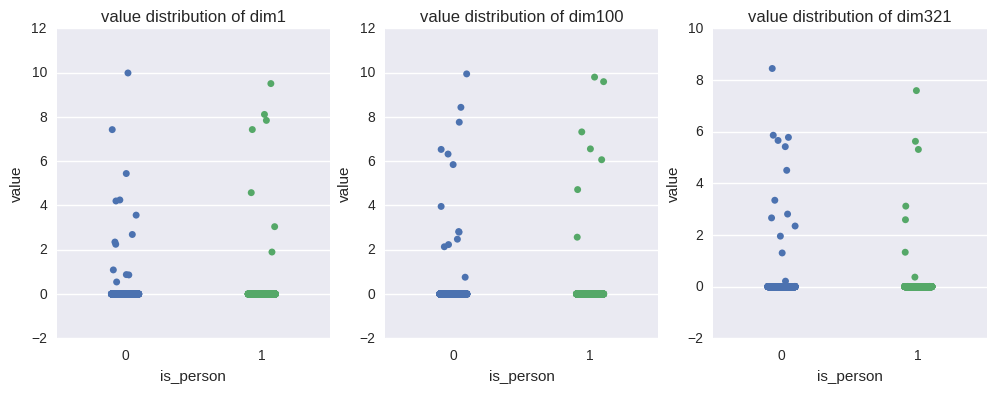


I take 3 attributes(dim1,dim100,dim321) as samples to see if the data contains outliers.
From the plots, we could see that that data set truely contains outliers.
Also, it seems that the outliers have the value > 1.0.
So, for next step, I want to remove the outliers.
Also, after removing the outliers, I use a StandardScaler to scale the data so that the data is suitable for training a SVM classifier.
Here is the means and standard deviations for the cleaning data.

Means for the first 5 attributes:
[ -3.395e-17  -2.207e-17   2.444e-16   1.426e-16  -5.771e-17]
Standard deviations for the first 5 attributes:
[ 1.  1.  1.  1.  1.]

Using the clean data to train a SVM model.

The accuracy of a simple SVM classifier on training data: 0.8347
The accuracy of a simple SVM classifier on validation data: 0.7215

Now, I get a simple SVM classifier. For the next step, I want to tune the parameter for the classifier.



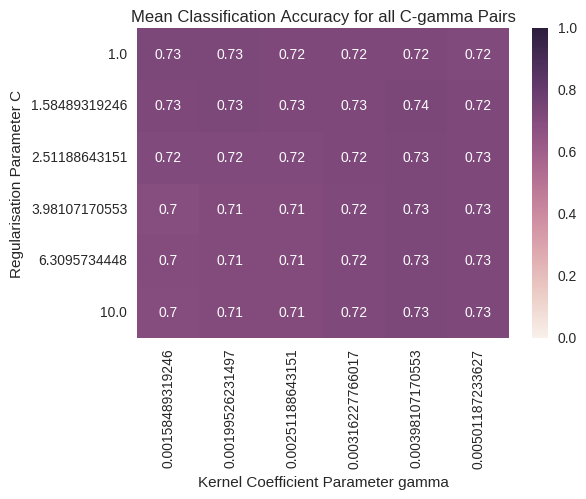

The value of the optimal regularisation parameter C is: 1.5849
The value of the optimal kernel coefficient parameter gamma is: 0.0040
The classification accuracy of optimal pairs SVC on training set is: 1.0000
The classification accuracy of optimal pairs SVC on validation set is: 0.7367

Considering that not all the features are usful in doing classification, 
I want to remove some of features to see if it helps to improve the performance.
Select the usefult features using the importance of RandomTreeClassifier.
I choose the features by the importances generated from RandomTreeClassifier.



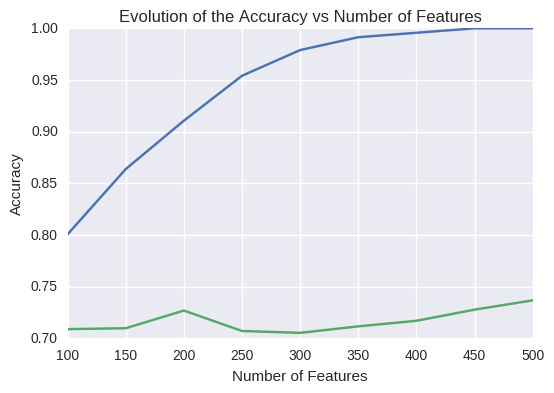

The highest accuracy this model could get on validation is : 0.736748
The number of features for this model is: 500

It seems that the 500 features work fine.


So far, the final classifier I got in this task is a tuned SVM classifier.

The regularisation parameter C of this model is: 1.5849
The kernel coefficient parameter gamma of this model is: 0.0040
The accuracy on validation set is: 0.7367
The log loss on validation set is: 0.6691


In [28]:
# Your code goes here
np.set_printoptions(precision=3)

print(
'''
After loading the dataset, for the first step, I want to see if there are outliers in the data set.
So, I first plot some of attributes to see how the data distribute.
'''
)
data_path = os.path.join(os.getcwd(), 'datasets', 'train_images_partB.csv')
mc_train = pd.read_csv(data_path, delimiter = ',')
data_path = os.path.join(os.getcwd(), 'datasets', 'valid_images_partB.csv')
mc_val = pd.read_csv(data_path, delimiter = ',')
data_path = os.path.join(os.getcwd(), 'datasets', 'test_images_partB.csv')
mc_test = pd.read_csv(data_path, delimiter = ',')

#detect the outliers
plt.figure(figsize=(12,4))
plt.subplot(131)
sns.stripplot(y=mc_train.dim1,x=mc_train.is_person,jitter=0.1)
plt.xlabel('is_person')
plt.ylabel('value')
plt.title('value distribution of dim1')
plt.subplot(132)
sns.stripplot(y=mc_train.dim100,x=mc_train.is_person,jitter=0.1)
plt.xlabel('is_person')
plt.ylabel('value')
plt.title('value distribution of dim100')
plt.subplot(133)
sns.stripplot(y=mc_train.dim321,x=mc_train.is_person,jitter=0.1)
plt.xlabel('is_person')
plt.ylabel('value')
plt.title('value distribution of dim321')

plt.show()

print(
'''
I take 3 attributes(dim1,dim100,dim321) as samples to see if the data contains outliers.
From the plots, we could see that that data set truely contains outliers.
Also, it seems that the outliers have the value > 1.0.
So, for next step, I want to remove the outliers.
Also, after removing the outliers, I use a StandardScaler to scale the data so that the data is suitable for training a SVM classifier.
Here is the means and standard deviations for the cleaning data.
'''
)

mc_train.drop('imgId',axis=1,inplace = True)
mc_val.drop('imgId',axis=1,inplace=True)
mc_clean_train = mc_train[mc_train<1.01].dropna(axis=0)
mc_clean_X_tr = mc_clean_train.iloc[:,:500]
mc_clean_y_tr = mc_clean_train.is_person
mc_clean_ft_tr = mc_clean_train.iloc[:,500:519].drop('is_person',axis=1)
mc_clean_X_val = mc_val.iloc[:,:500]
mc_clean_y_val = mc_val.is_person
mc_clean_ft_val = mc_val.iloc[:,500:519].drop('is_person',axis=1)

mc_ss = StandardScaler()
mc_ss.fit(mc_clean_X_tr)
mc_clean_X_tr_tran = mc_ss.transform(mc_clean_X_tr)
mc_clean_X_val_tran = mc_ss.transform(mc_clean_X_val)

print("Means for the first 5 attributes:\n{0}".format(mc_clean_X_tr_tran[:,:5].mean(axis=0)))
print("Standard deviations for the first 5 attributes:\n{0}".format(mc_clean_X_tr_tran[:,:5].std(axis=0)))
print(
'''
Using the clean data to train a SVM model.
'''
)

mc_svm = SVC(kernel='rbf',C=1.0,gamma=0.001)
mc_svm.fit(mc_clean_X_tr_tran,mc_clean_y_tr)
print("The accuracy of a simple SVM classifier on training data: {0:.4f}".format(mc_svm.score(mc_clean_X_tr_tran,mc_clean_y_tr)))
print("The accuracy of a simple SVM classifier on validation data: {0:.4f}".format(mc_svm.score(mc_clean_X_val_tran,mc_clean_y_val)))
print(
'''
Now, I get a simple SVM classifier. For the next step, I want to tune the parameter for the classifier.
'''
    )
# Tune SVM
mc_C = np.logspace(0, 1, 6)
mc_gamma = np.logspace(-2.8, -2.3, 6)

tune_score = np.zeros((6,6))
Ccount = 0
Gammacount = 0

mc_kf = KFold(mc_clean_X_tr_tran.shape[0], n_folds = 3, shuffle = True, random_state = 0)

for c in mc_C:
    for gamma in mc_gamma:        
        tune_svm = SVC(kernel = 'rbf',C = c,gamma = gamma)
        tune_svm.fit(mc_clean_X_tr_tran,mc_clean_y_tr)
        tune_score[Ccount,Gammacount] = tune_svm.score(mc_clean_X_val_tran,mc_clean_y_val)
        Gammacount += 1
    Gammacount = 0
    Ccount += 1

sns.heatmap(data = tune_score, xticklabels=mc_gamma, yticklabels=mc_C, vmin=0., vmax=1., annot=True)
plt.ylabel('Regularisation Parameter C')
plt.xlabel('Kernel Coefficient Parameter gamma')
plt.title('Mean Classification Accuracy for all C-gamma Pairs')
plt.show()

optimal_C = mc_C[np.unravel_index(tune_score.argmax(),[6,6])[0]]
optimal_gamma = mc_gamma[np.unravel_index(tune_score.argmax(),[6,6])[1]]
print("The value of the optimal regularisation parameter C is: {0:.4f}".format(optimal_C))
print("The value of the optimal kernel coefficient parameter gamma is: {0:.4f}".format(optimal_gamma))

mc_svm = SVC(kernel='rbf', C = optimal_C, gamma = optimal_gamma,probability=True)
mc_svm.fit(mc_clean_X_tr_tran,mc_clean_y_tr)
opt_svm_train_score = mc_svm.score(mc_clean_X_tr_tran,mc_clean_y_tr)
opt_svm_val_score = mc_svm.score(mc_clean_X_val_tran,mc_clean_y_val)

print("The classification accuracy of optimal pairs SVC on training set is: {0:.4f}".format(opt_svm_train_score))
print("The classification accuracy of optimal pairs SVC on validation set is: {0:.4f}".format(opt_svm_val_score))

print(
'''
Considering that not all the features are usful in doing classification, 
I want to remove some of features to see if it helps to improve the performance.
Select the usefult features using the importance of RandomTreeClassifier.
I choose the features by the importances generated from RandomTreeClassifier.
'''
)

mc_sf_rtc = RandomForestClassifier(criterion='entropy',random_state=0)
mc_sf_rtc.fit(mc_clean_X_tr_tran,mc_clean_y_tr)

mc_num_select = [100,150,200,250,300,350,400,450,500]

mc_sf_acc_train = np.zeros(9)
#GridsearchCV
mc_sf_acc_val = np.zeros(9)

epoch = 0
for i in mc_num_select:
    sf_feature_index = mc_sf_rtc.feature_importances_.argsort()[-i:][::-1]
    sf_imp_feature = mc_clean_X_tr.iloc[:0,sf_feature_index]
    

    mc_sf_X_train = np.zeros((mc_clean_X_tr_tran.shape[0],i))
    mc_sf_X_val = np.zeros((mc_clean_X_val_tran.shape[0],i))
    count=0
    for item in sf_imp_feature:
        mc_sf_X_train[:,count]=mc_clean_X_tr.loc[:,item]
        mc_sf_X_val[:,count]=mc_clean_X_val.loc[:,item]
        count += 1
    
    mc_sf_ss = StandardScaler()
    mc_sf_ss.fit(mc_sf_X_train)
    mc_sf_X_train_tran = mc_sf_ss.transform(mc_sf_X_train)
    mc_sf_X_val_tran = mc_sf_ss.transform(mc_sf_X_val)
    
    mc_sf_svm = SVC(kernel='rbf',C=optimal_C,gamma=optimal_gamma)
    mc_sf_svm.fit(mc_sf_X_train_tran,mc_clean_y_tr)    
    mc_sf_acc_train[epoch] = mc_sf_svm.score(mc_sf_X_train_tran,mc_clean_y_tr)
    mc_sf_acc_val[epoch] = mc_sf_svm.score(mc_sf_X_val_tran,mc_clean_y_val)
    #print("{0}: {1}".format(i,mc_sf_acc_train[count]))
    #print("{0}: {1}\n".format(i,mc_sf_acc_val[count]))
    epoch += 1

plt.plot(mc_num_select,mc_sf_acc_train)
plt.plot(mc_num_select,mc_sf_acc_val)
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.title('Evolution of the Accuracy vs Number of Features')
plt.show()

print("The highest accuracy this model could get on validation is : {0:4f}".format(mc_sf_acc_val.max()))
print("The number of features for this model is: {0}".format(mc_num_select[mc_sf_acc_val.argmax()]))

print(
'''
It seems that the 500 features work fine.
'''
)
mc_val_prob = mc_svm.predict_proba(mc_sf_X_val_tran)
mc_val_log_loss = log_loss(mc_clean_y_val,mc_val_prob)

print(
'''
So far, the final classifier I got in this task is a tuned SVM classifier.
'''
)

print("The regularisation parameter C of this model is: {0:.4f}".format(optimal_C))
print("The kernel coefficient parameter gamma of this model is: {0:.4f}".format(optimal_gamma))
print("The accuracy on validation set is: {0:.4f}".format(opt_svm_val_score))
print("The log loss on validation set is: {0:.4f}".format(mc_val_log_loss))


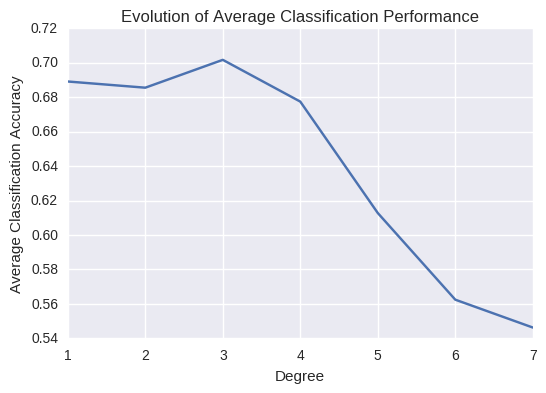

The classification accuracy of optimal(degree) poly SVC on training set is: 0.9909
The classification accuracy of optimal(degree) poly SVC on validation set is: 0.7017


In [29]:
mc_degree = range(1,8)

mc_tune_score = np.zeros(7)
degree_count = 0

for degree in mc_degree:
    tune_svm = SVC(kernel='poly',degree = degree)
    tune_svm.fit(mc_clean_X_tr_tran,mc_clean_y_tr)
    mc_tune_score[degree_count] = tune_svm.score(mc_clean_X_val_tran,mc_clean_y_val)
    degree_count += 1

plt.plot(mc_degree,mc_tune_score)
plt.xlabel('Degree')
plt.ylabel('Average Classification Accuracy')
plt.title('Evolution of Average Classification Performance')
plt.show()

mc_optimal_degree = mc_degree[mc_tune_score.argmax()]

mc_poly_fin = SVC(kernel='poly',degree=mc_optimal_degree,probability=True)
mc_poly_fin.fit(mc_clean_X_tr_tran,mc_clean_y_tr)
mc_poly_fin_score_tr = mc_poly_fin.score(mc_clean_X_tr_tran,mc_clean_y_tr)
mc_poly_fin_score_val = mc_poly_fin.score(mc_clean_X_val_tran,mc_clean_y_val)
print("The classification accuracy of optimal(degree) poly SVC on training set is: {0:.4f}".format(mc_poly_fin_score_tr))
print("The classification accuracy of optimal(degree) poly SVC on validation set is: {0:.4f}".format(mc_poly_fin_score_val))

In [30]:
mc_test_clean = mc_test.drop('is_person',axis=1)
mc_test_clean_tran = mc_ss.transform(mc_test_clean)

pred_proba = mc_svm.predict_proba(mc_test_clean_tran)


In [31]:
# Execute this cell to export your results
from numpy import savetxt
def save_predictions(pred_proba):
    if pred_proba.shape != (1114,2):
        raise ValueError('Predicted probabilities array has not the right shape.')
    
    savetxt('assignment_3_predictions.txt', pred_proba)

save_predictions(pred_proba) # You need to replace "pred_proba" with the name of the array
                             # which contains the probability estimates for the data in 
                             # the test set.

*Your answer goes here*

Below are some aspects that I have considered during the process of building this model.

First of all, it's the dataset it self. In pre-process, I plot some attributes first to see if they contain some outliers. After removing the outliers, I scale the data so that they are suitable for training.

Secondly, with the experience of above practice, I choose SVC with rbf kernel to train the first model. In order to choose the most suitable parameters for this model, I use different pairs of C and gamma to optimise the performance.

After that, I'am considering to simplify the features I use. Considering that not all the features are useful in the model. I select different numbers of features according to the importance generated from a RandomForrestClassifier and plot the performance for each epoch. However, it seems that the whole features provide the best performance.

Finally, to compare the performance of different kernrls, I also build a SVC with poly kernel. But, it doesn't provide a better result.

Also, I've tried many different ideas. I want make the use of is_xxx attributes because they are binary and I could use them to train a decision tree to improve the performance of SVC. In my plan, I want to calculate the joint probability of is_xxx attributes and is_person. To do this, the first step is to predict the other is_xxx attributes. I tried many methods to do this, but I only got the accuracy of around 0.5, which is lower than the baseline. So, I give up this idea. Of course, I think the reason of the low accuracy of these targets is that the dataset contains too less samples of these targets(only around 200 samples for each of 2113 samples). I believe this model could work if the dataset contains more samples of them. 